Conduction instationnaire en 2D Résolution implicite - CL de type Dirichlet

$T(x,y) = T_2 + \frac{4(T_1 - T_2)}{\pi} \sum_{n=0}^{\infty} \frac{1}{2n+1} \sin\left(\frac{(2n+1)\pi x}{L_x}\right) \frac{\sinh\left(\frac{(L_y-y)(2n+1)\pi}{L_x}\right)}{\sinh\left(\frac{(2n+1)\pi L_y}{L_x}\right)}$

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [97]:
# Paramètres
Lx, Ly = 1.0, 1.0  # Dimensions
Nx, Ny = 50, 50   # Nombre de points
dx, dy = Lx / Nx, Ly / Ny  # Pas spatiaux
dt = 0.01         # Pas de temps
a = 0.01          # Diffusivité thermique
T0, T1, T2 = 50, 100, 0   # Températures imposées

In [98]:
# Grilles spatiales
x = np.linspace(0, Lx, Nx+1)
y = np.linspace(0, Ly, Ny+1)
X, Y = np.meshgrid(x, y)

In [99]:
# Initialisation de la solution numérique
T_num = np.ones((Ny+1, Nx+1)) * T2
T_num[0,:] = T1  # CL sur y=0

In [100]:
# Fonction analytique pour T(x, y)
def T_analytique(x, y, T1, T2, Lx, Ly, N_terms=50):
    T = T2
    for n in range(N_terms):
        coef = (4 * (T1 - T2)) / (math.pi * (2*n + 1))
        sin_term = np.sin((2*n + 1) * math.pi * x / Lx)
        sinh_num = np.sinh((Ly - y) * (2*n + 1) * math.pi / Lx)
        sinh_den = np.sinh((2*n + 1) * math.pi * Ly / Lx)
        T += coef * sin_term * sinh_num / sinh_den
    return T


In [101]:
# Méthode numérique simple : itération explicite
alpha_x = a * dt / dx**2
alpha_y = a * dt / dy**2
t_max = 0.1
nt = int(t_max / dt)

for t in range(nt):
    T_new = T_num.copy()
    for i in range(1, Ny):
        for j in range(1, Nx):
            T_new[i, j] = T_num[i, j] + alpha_x * (T_num[i, j+1] - 2*T_num[i, j] + T_num[i, j-1]) \
                                       + alpha_y * (T_num[i+1, j] - 2*T_num[i, j] + T_num[i-1, j])
    T_num = T_new.copy()

print(alpha_x, alpha_y)

0.25 0.25


In [120]:
# Condition initiale
u = np.ones((Ny+1, Nx+1)) * T2
u[0,:] = T1  # CL sur y=0

In [ ]:
# Méthode numérique implicite ADI

# Fonctions pour résoudre dans les directions x et y
def step_x(u, dx, dy, dt, a):
    """Effectuer un pas dans la direction x (schéma implicite en x et explicite en y)."""
    Nx, Ny = u.shape
    u_new = u.copy()
    for j in range(Ny):
        # Matrice tridiagonale pour résoudre l'équation implicite
        A = np.diag((1 + 2 * a * dt / dx**2) * np.ones(Nx - 2)) + \
            np.diag(-a * dt / dx**2 * np.ones(Nx - 3), 1) + \
            np.diag(-a * dt / dx**2 * np.ones(Nx - 3), -1)
        
        # Le côté droit de l'équation (valeurs aux bords de chaque ligne)
        b = u[1:Nx-1, j] + a * dt / dx**2 * (u[0:Nx-2, j] - 2*u[1:Nx-1, j] + u[2:Nx, j])
        
        # Résolution de l'équation tridiagonale
        u_new[1:Nx-1, j] = np.linalg.solve(A, b)
    return u_new

def step_y(u, dx, dy, dt, a):
    """Effectuer un pas dans la direction y (schéma implicite en y et explicite en x)."""
    Nx, Ny = u.shape
    u_new = u.copy()
    for i in range(Nx):
        # Matrice tridiagonale pour résoudre l'équation implicite
        A = np.diag((1 + 2 * a * dt / dy**2) * np.ones(Ny - 2)) + \
            np.diag(-a * dt / dy**2 * np.ones(Ny - 3), 1) + \
            np.diag(-a * dt / dy**2 * np.ones(Ny - 3), -1)
        
        # Le côté droit de l'équation (valeurs aux bords de chaque colonne)
        b = u[i, 1:Ny-1] + a * dt / dy**2 * (u[i, 0:Ny-2] - 2*u[i, 1:Ny-1] + u[i, 2:Ny])
        
        # Résolution de l'équation tridiagonale
        u_new[i, 1:Ny-1] = np.linalg.solve(A, b)
        
    return u_new

In [122]:
# Temps de simulation
T_max = 4.0  # Temps final
n_steps = int(T_max / dt)

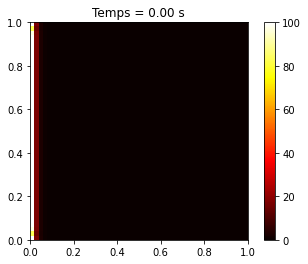

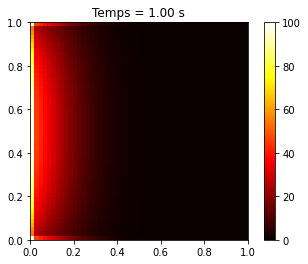

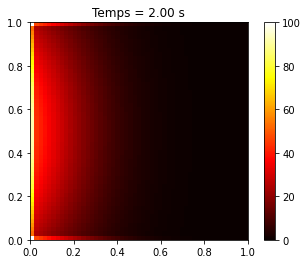

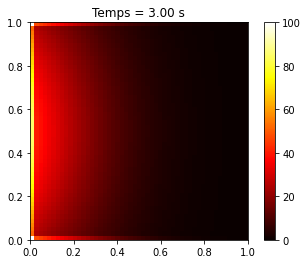

In [123]:
# Boucle temporelle pour la méthode ADI
for n in range(n_steps):
    # Étape dans la direction x
    u = step_x(u, dx, dy, dt, a)
    
    # Étape dans la direction y
    u = step_y(u, dx, dy, dt, a)
    
    if n % 100 == 0:  # Affichage tous les 100 pas
        plt.imshow(u.T, origin='lower', cmap='hot', extent=[0, Lx, 0, Ly])
        plt.colorbar()
        plt.title(f'Temps = {n * dt:.2f} s')
        plt.show()

In [102]:
# Calcul de la solution analytique
T_exact = T_analytique(X, Y, T1, T2, Lx, Ly)

In [103]:
# Calcul de la différence
T_diff = np.abs(T_exact - T_num)

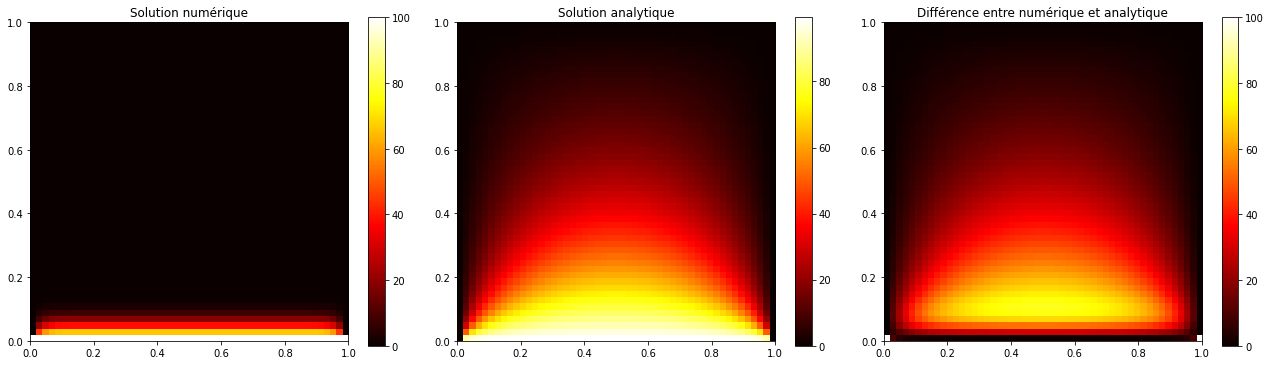

In [104]:
# Visualisation des résultats
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Solution numérique
im1 = axs[0].imshow(T_num, extent=[0, Lx, 0, Ly], origin='lower', cmap='hot')
axs[0].set_title('Solution numérique')
fig.colorbar(im1, ax=axs[0])

# Solution analytique
im2 = axs[1].imshow(T_exact, extent=[0, Lx, 0, Ly], origin='lower', cmap='hot')
axs[1].set_title('Solution analytique')
fig.colorbar(im2, ax=axs[1])

# Différence
im3 = axs[2].imshow(T_diff, extent=[0, Lx, 0, Ly], origin='lower', cmap='hot')
axs[2].set_title('Différence entre numérique et analytique')
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()